In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.2 MB/s eta 0:00:00


In [3]:

df = pd.read_csv("/content/DataCoSupplyChainDataset.csv", encoding="ISO-8859-1")

In [4]:

df['order_date'] = pd.to_datetime(df['order date (DateOrders)'], errors='coerce')

<ipython-input-4-f77566f2d34e>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['order_date'] = pd.to_datetime(df['order date (DateOrders)'], errors='coerce')


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 54 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   ï»¿Type                        180519 non-null  object        
 1   Days for shipping (real)       180519 non-null  int64         
 2   Days for shipment (scheduled)  180519 non-null  int64         
 3   Benefit per order              180519 non-null  float64       
 4   Sales per customer             180519 non-null  float64       
 5   Delivery Status                180519 non-null  object        
 6   Late_delivery_risk             180519 non-null  int64         
 7   Category Id                    180519 non-null  int64         
 8   Category Name                  180519 non-null  object        
 9   Customer City                  180519 non-null  object        
 10  Customer Country               180519 non-null  object        
 11  

In [6]:
df['Sales']

,Sales
0,327.750000
1,327.750000
2,327.750000
3,327.750000
4,327.750000
...,...
180514,399.980011
180515,399.980011
180516,399.980011
180517,399.980011


In [7]:
df = df.dropna(subset=['order_date', 'Sales'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 54 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   ï»¿Type                        180519 non-null  object        
 1   Days for shipping (real)       180519 non-null  int64         
 2   Days for shipment (scheduled)  180519 non-null  int64         
 3   Benefit per order              180519 non-null  float64       
 4   Sales per customer             180519 non-null  float64       
 5   Delivery Status                180519 non-null  object        
 6   Late_delivery_risk             180519 non-null  int64         
 7   Category Id                    180519 non-null  int64         
 8   Category Name                  180519 non-null  object        
 9   Customer City                  180519 non-null  object        
 10  Customer Country               180519 non-null  object        
 11  

In [9]:
df_daily = df.groupby(df['order_date'].dt.date)['Sales'].sum().reset_index()
df_daily.columns = ['order_date', 'Sales']

In [10]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127 entries, 0 to 1126
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_date  1127 non-null   object 
 1   Sales       1127 non-null   float64
dtypes: float64(1), object(1)
memory usage: 17.7+ KB


In [11]:
df_daily['order_date'] = pd.to_datetime(df_daily['order_date'])
df_daily = df_daily.sort_values('order_date')

In [12]:
df_daily.set_index('order_date', inplace=True)

In [13]:
full_range = pd.date_range(start=df_daily.index.min(), end=df_daily.index.max(), freq='D')

In [14]:
df_daily = df_daily.reindex(full_range)
df_daily.index.name = 'order_date'
df_daily['Sales'] = df_daily['Sales'].fillna(0)

In [15]:
df_daily.reset_index(inplace=True)

In [16]:
df_daily.head()

,order_date,Sales
0,2015-01-01,32806.090690
1,2015-01-02,29818.210575
2,2015-01-03,36348.710648
3,2015-01-04,35738.970669
4,2015-01-05,31067.910603


In [20]:
df_daily.to_csv('sales_forecasting.csv', index=False)

In [17]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127 entries, 0 to 1126
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   order_date  1127 non-null   datetime64[ns]
 1   Sales       1127 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.7 KB


In [18]:
df_plot = df_daily.copy()

In [19]:
df_plot['7_day_avg'] = df_plot['Sales'].rolling(7).mean()
df_plot['30_day_avg'] = df['Sales'].rolling(30).mean()

####Raw Sales + Rolling Avg

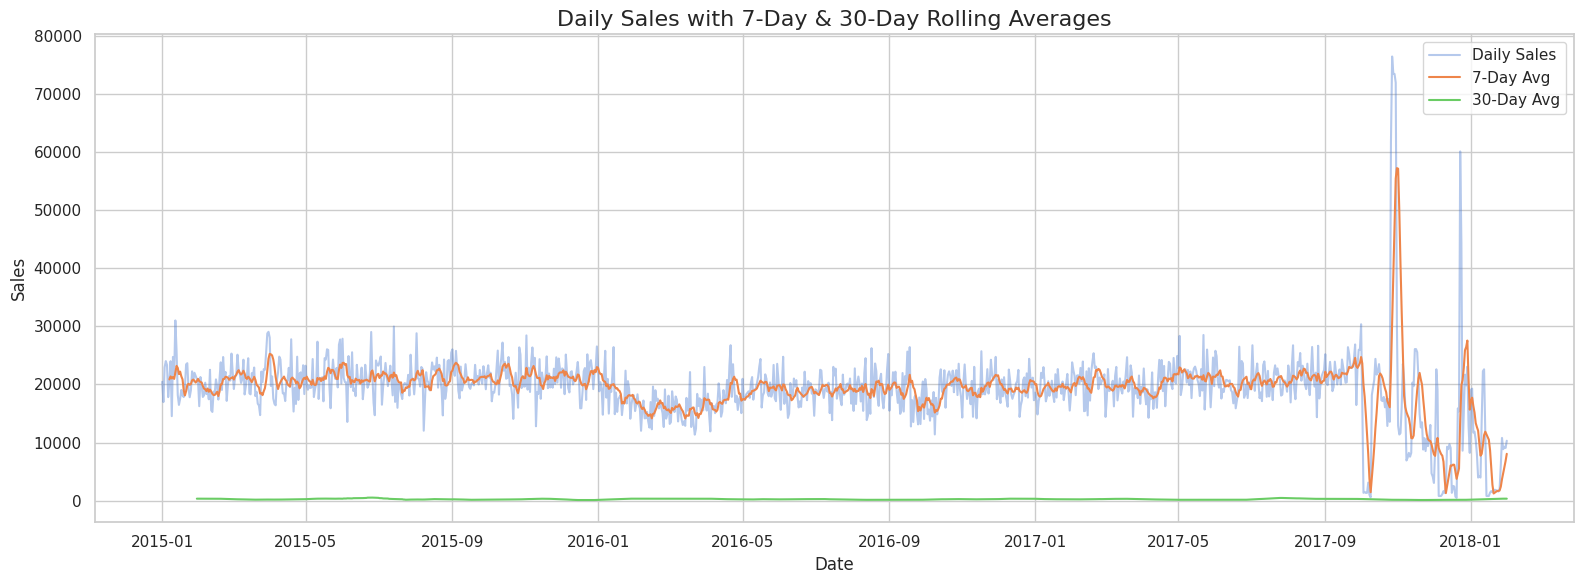

In [ ]:
sns.set(style="whitegrid", palette="muted")

plt.figure(figsize=(16, 6))
sns.lineplot(data=df_plot, x='order_date', y='Sales', label='Daily Sales', alpha=0.4)
sns.lineplot(data=df_plot, x='order_date', y='7_day_avg', label='7-Day Avg')
sns.lineplot(data=df_plot, x='order_date', y='30_day_avg', label='30-Day Avg')
plt.title('Daily Sales with 7-Day & 30-Day Rolling Averages', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()


## 📊 Daily Sales with Rolling Averages

This plot displays daily sales along with 7-day and 30-day rolling averages to highlight short-term and long-term trends.

### Key Insights:
- Sales remain relatively stable from 2015 to mid-2017.
- A sharp spike occurs around mid-2017, followed by a rapid decline, potentially indicating a one-time event or data issue.
- The 7-day average tracks short-term fluctuations, while the 30-day average smooths longer-term patterns but flattens post-spike due to low sales values.

Further investigation is needed to understand the anomaly and assess its impact on forecasting.


####  Monthly Sales Trend (Barplot)


<ipython-input-21-50d727df015e>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_sales, x='MonthYear', y='Sales', palette='Blues_d')


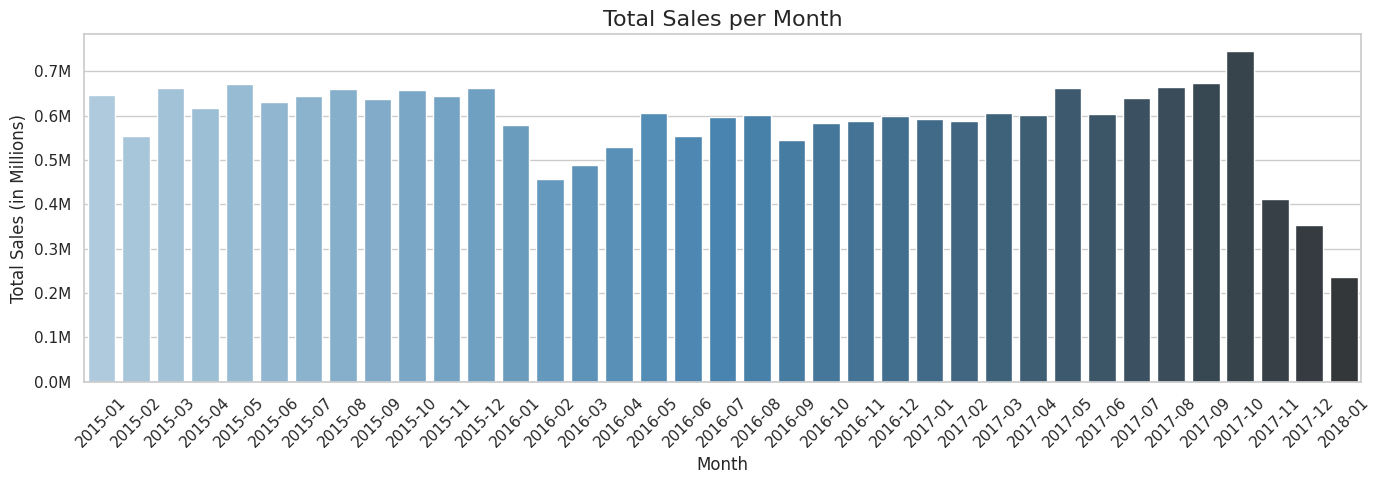

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_plot['MonthYear'] = df_plot['order_date'].dt.to_period('M').astype(str)

monthly_sales = df_plot.groupby('MonthYear')['Sales'].sum().reset_index()

# Assuming you already have `monthly_sales` dataframe
plt.figure(figsize=(14, 5))
sns.barplot(data=monthly_sales, x='MonthYear', y='Sales', palette='Blues_d')

# Format y-axis to show in millions
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

plt.xticks(rotation=45)
plt.title('Total Sales per Month', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Total Sales (in Millions)')
plt.tight_layout()
plt.show()


## 📊 Total Sales per Month

The chart visualizes aggregated monthly sales over the 3-year period.

### Key Insights:
- Sales remained consistently strong (~1M/month) from early 2015 through mid-2017.
- A noticeable increase occurred around mid-2017, peaking in August 2017.
- Post-September 2017, there is a sharp decline, indicating a potential operational disruption, seasonal closure, or data truncation.

This pattern should be considered while forecasting future sales, especially accounting for the post-peak drop.


#### Weekly Seasonality Pattern (Boxplot)

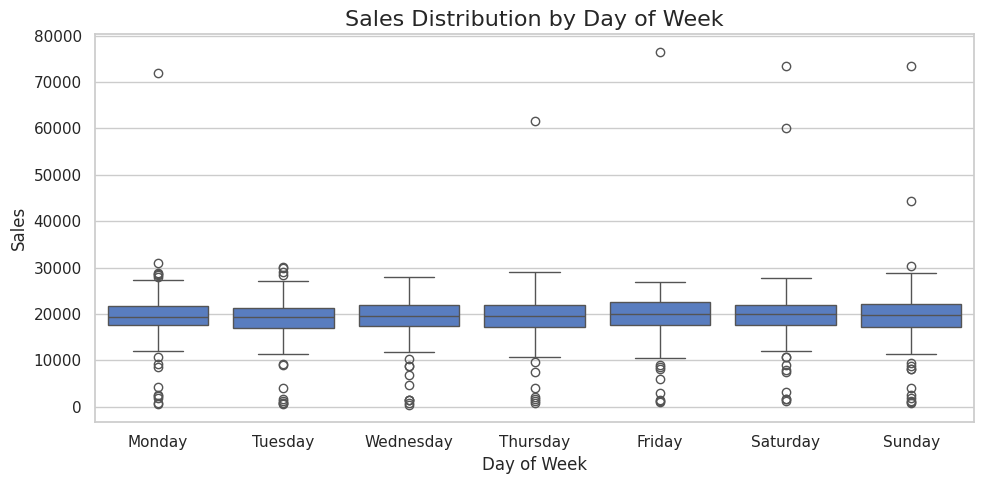

In [ ]:
df_plot['DayOfWeek'] = df_plot['order_date'].dt.day_name()

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_plot, x='DayOfWeek', y='Sales', order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
plt.title('Sales Distribution by Day of Week', fontsize=16)
plt.xlabel('Day of Week')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()


## 📦 Sales Distribution by Day of Week

This boxplot illustrates how daily sales vary across different days of the week.

### Key Insights:
- Sales are relatively consistent across all weekdays and weekends, with median values staying around the same range.
- Outliers are present on all days, with the **highest spikes occurring on Mondays and Sundays**, possibly indicating occasional high-volume sales or data anomalies.
- The distribution spread is similar across days, suggesting no strong day-of-week effect on average sales performance.

This indicates that weekday vs. weekend does not significantly impact daily sales, simplifying modeling assumptions.


####  Seasonal Decomposition

<Figure size 1800x1200 with 0 Axes>

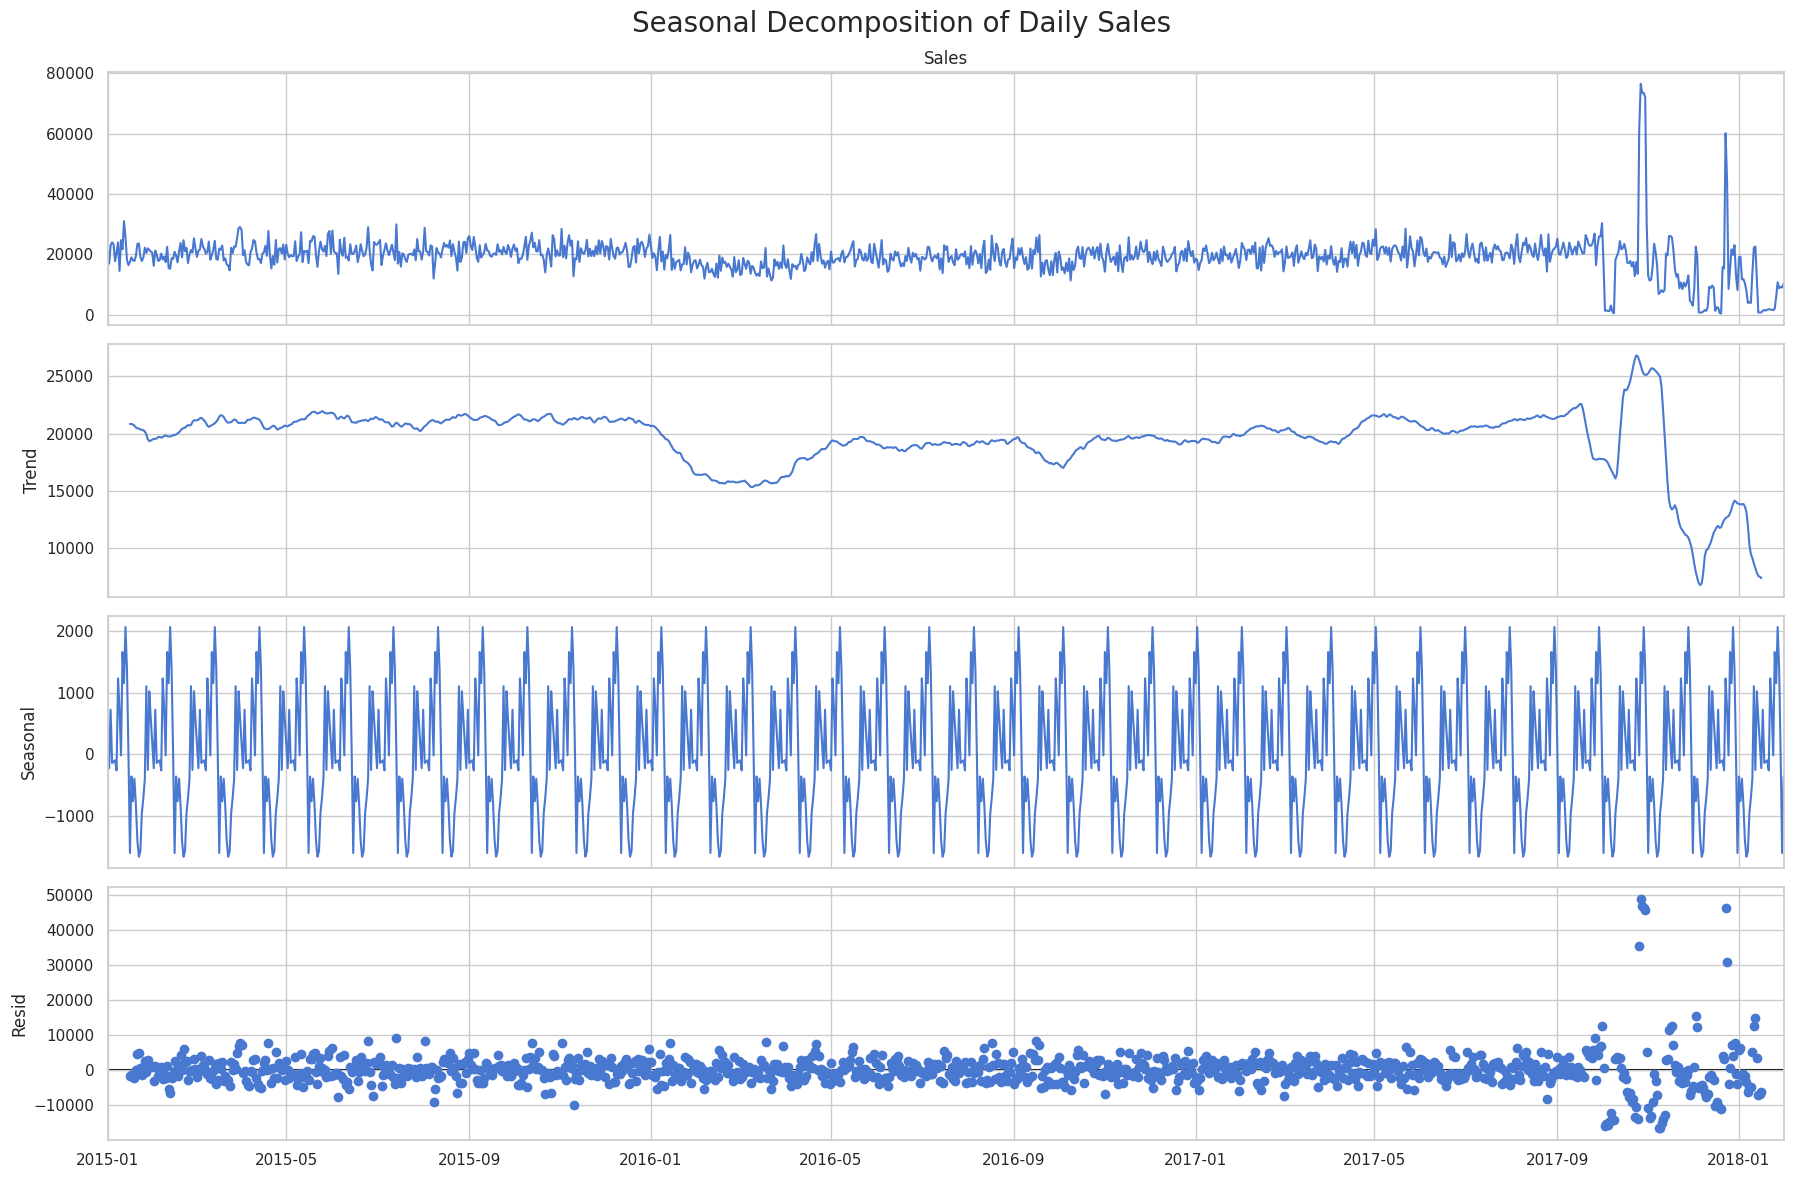

In [ ]:
# Decomposition
df_seasonal = df_daily.copy()
df_seasonal.set_index('order_date', inplace=True)
result = seasonal_decompose(df_seasonal['Sales'], model='additive', period=30)

# Plot with larger size
fig = plt.figure(figsize=(18, 12))
fig = result.plot()
fig.set_size_inches(18, 12)
plt.suptitle("Seasonal Decomposition of Daily Sales", fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
# Use original series
series = df_daily['Sales']

# Augmented Dickey-Fuller test
adf_result = adfuller(series)
print("ADF Test:")
print(f"  Test Statistic: {adf_result[0]:.4f}")
print(f"  p-value: {adf_result[1]:.4f}")

ADF Test:
  Test Statistic: -5.3413
  p-value: 0.0000


####  ACF and PACF plots


<Figure size 1600x600 with 0 Axes>

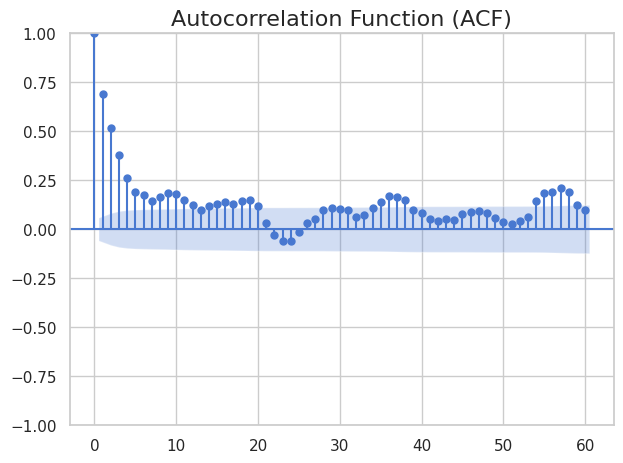

<Figure size 1600x600 with 0 Axes>

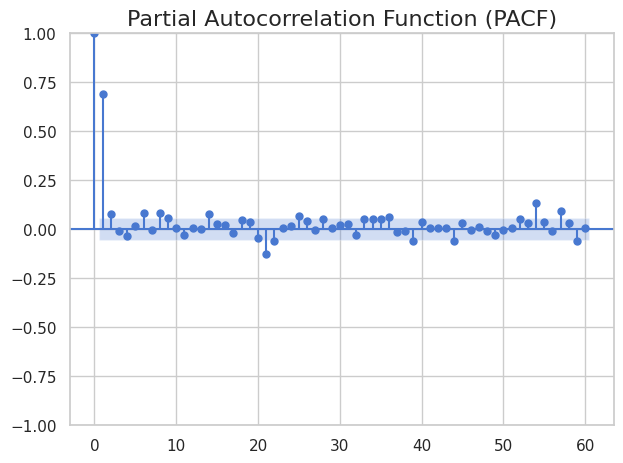

In [ ]:
# ACF
plt.figure(figsize=(16, 6))
plot_acf(df_seasonal['Sales'], lags=60)
plt.title('Autocorrelation Function (ACF)', fontsize=16)
plt.tight_layout()
plt.show()

# PACF
plt.figure(figsize=(16, 6))
plot_pacf(df_seasonal['Sales'], lags=60)
plt.title('Partial Autocorrelation Function (PACF)', fontsize=16)
plt.tight_layout()
plt.show()

## ACF & PACF Analysis

The ACF shows a gradual decay, while the PACF cuts off after lag 1, suggesting an ARIMA model with AR(1) and MA(1–2) components.

### Selected Parameters:
- **p = 1** (from PACF)
- **d = 0** (ADF test confirms stationarity)
- **q = 1 or 2** (from ACF)

Models ARIMA(1, 0, 1) and ARIMA(1, 0, 2) will be evaluated as baseline forecasting candidates.


### Baseline models

In [ ]:
# Re-set the index for time series
df_baseline = df_daily.copy()
df_baseline.set_index('order_date', inplace=True)

In [ ]:
# Train-test split (80-20)
split_index = int(len(df_baseline) * 0.8)
train = df_baseline.iloc[:split_index]
test = df_baseline.iloc[split_index:]

In [ ]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 901 entries, 2015-01-01 to 2017-06-19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   901 non-null    float64
dtypes: float64(1)
memory usage: 14.1 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 226 entries, 2017-06-20 to 2018-01-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   226 non-null    float64
dtypes: float64(1)
memory usage: 3.5 KB


(None, None)

### 1. Naïve Forecast

In [ ]:
# Naïve forecast: use previous day's sales
naive_forecast = test['Sales'].shift(1)

# Drop the first row (contains NaN due to shift)
naive_actual = test['Sales'].iloc[1:]
naive_pred = naive_forecast.iloc[1:]

# Evaluate
naive_rmse = np.sqrt(mean_squared_error(naive_actual, naive_pred))
naive_mae = mean_absolute_error(naive_actual, naive_pred)

print(f"Naïve Forecast RMSE: {naive_rmse:.2f}")
print(f"Naïve Forecast MAE: {naive_mae:.2f}")

Naïve Forecast RMSE: 7534.70
Naïve Forecast MAE: 3978.51


### 7-Day Moving Average

In [ ]:
moving_avg_forecast = train['Sales'].rolling(window=7).mean().iloc[-1]
moving_avg_forecast = [moving_avg_forecast] * len(test)
ma_rmse = np.sqrt(mean_squared_error(test['Sales'], moving_avg_forecast))
print(f"Moving Average RMSE: {ma_rmse:.2f}")


Moving Average RMSE: 11891.98


### 3. Simple Exponential Smoothing

In [ ]:

ses_model = SimpleExpSmoothing(train['Sales']).fit()
ses_forecast = ses_model.forecast(len(test))
ses_rmse = np.sqrt(mean_squared_error(test['Sales'], ses_forecast))
print(f"Exponential Smoothing RMSE: {ses_rmse:.2f}")

Exponential Smoothing RMSE: 12035.98


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
model = ARIMA(train['Sales'], order=(1, 0, 1))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))
forecast.index = test.index

# Evaluation
rmse = np.sqrt(mean_squared_error(test['Sales'], forecast))
mae = mean_absolute_error(test['Sales'], forecast)

print(f"ARIMA(1,0,1) RMSE: {rmse:.2f}")
print(f"ARIMA(1,0,1) MAE: {mae:.2f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1,0,1) RMSE: 12099.69
ARIMA(1,0,1) MAE: 7734.10


In [ ]:
# Fit ARIMA(1,1,1)
model_111 = ARIMA(train['Sales'], order=(1, 1, 1))
model_fit_111 = model_111.fit()

# Forecast
forecast_111 = model_fit_111.forecast(steps=len(test))
forecast_111.index = test.index

# Evaluation
rmse_111 = np.sqrt(mean_squared_error(test['Sales'], forecast_111))
mae_111 = mean_absolute_error(test['Sales'], forecast_111)

print(f"ARIMA(1,1,1) RMSE: {rmse_111:.2f}")
print(f"ARIMA(1,1,1) MAE: {mae_111:.2f}")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1,1,1) RMSE: 12082.79
ARIMA(1,1,1) MAE: 7704.70


In [ ]:
def evaluate_arima(order):
    model = ARIMA(train['Sales'], order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    forecast.index = test.index
    rmse = np.sqrt(mean_squared_error(test['Sales'], forecast))
    mae = mean_absolute_error(test['Sales'], forecast)
    print(f"ARIMA{order} → RMSE: {rmse:.2f}, MAE: {mae:.2f}")



In [ ]:
evaluate_arima((1,1,1))
evaluate_arima((1,1,2))
evaluate_arima((2,1,1))
evaluate_arima((2,1,2))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1) → RMSE: 12082.79, MAE: 7704.70


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 2) → RMSE: 12049.21, MAE: 7680.37


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 1) → RMSE: 12106.73, MAE: 7715.14


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 2) → RMSE: 12103.53, MAE: 7713.50


### Univariate LSTM

In [ ]:


# Step 1: Scale the sales values between 0 and 1
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(df_daily[['Sales']])

# Step 2: Create sliding window sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Set window size (e.g., 30 days)
window_size = 45
X, y = create_sequences(sales_scaled, window_size)

# Step 3: Train-test split (80-20)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Step 4: Reshape to (samples, timesteps, features)
# X is already in (samples, timesteps, 1) shape since each value is a single feature
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (865, 45, 1)
X_test shape: (217, 45, 1)


In [ ]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=64, activation='tanh', input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # optional
model.add(Dense(1))  # output layer

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 0.0320 - mae: 0.1506 - val_loss: 0.0232 - val_mae: 0.0966
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0027 - mae: 0.0411 - val_loss: 0.0226 - val_mae: 0.0929
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 - mae: 0.0341 - val_loss: 0.0229 - val_mae: 0.0934
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mae: 0.0365 - val_loss: 0.0225 - val_mae: 0.0923
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 - mae: 0.0332 - val_loss: 0.0226 - val_mae: 0.0927
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 - mae: 0.0346 - val_loss: 0.0225 - val_mae: 0.0923
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 - mae: 0.0335 - val_loss: 0.0224 - val_mae: 0.0920
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 - mae: 0.0346 - val_loss: 0.0225 - val_mae: 0.0925
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019

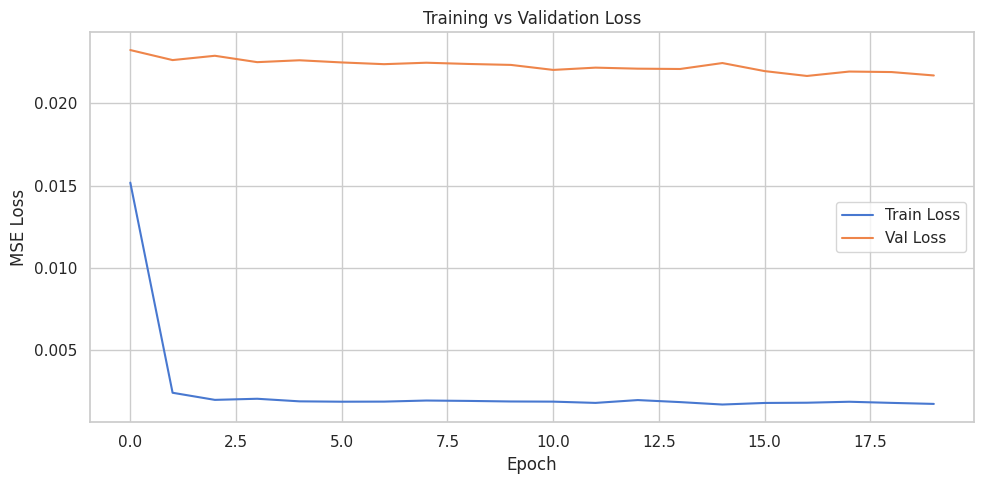

In [ ]:


plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Predict on test set
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions and true values
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_lstm = np.sqrt(mean_squared_error(y_true, y_pred))
mae_lstm = mean_absolute_error(y_true, y_pred)

print(f"LSTM RMSE: {rmse_lstm:.2f}")
print(f"LSTM MAE: {mae_lstm:.2f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
LSTM RMSE: 11201.60
LSTM MAE: 6895.11


### Multivariate LSTM

In [ ]:
# Add temporal features
df_features = df_daily.copy()
df_features['DayOfWeek'] = df_features['order_date'].dt.dayofweek
df_features['Month'] = df_features['order_date'].dt.month

# Add lag features
df_features['Lag_7_Sales'] = df_features['Sales'].shift(7)
df_features['Lag_30_Sales'] = df_features['Sales'].shift(30)

# Drop initial rows with NaNs due to lag
df_features.dropna(inplace=True)

# Scale features

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_features[['Sales', 'DayOfWeek', 'Month', 'Lag_7_Sales', 'Lag_30_Sales']])


In [ ]:
def create_multivariate_sequences(data, target_index, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i, target_index])  # target = Sales
    return np.array(X), np.array(y)

window_size = 45
X_mv, y_mv = create_multivariate_sequences(scaled, target_index=0, window_size=window_size)


In [ ]:
split = int(len(X_mv) * 0.8)
X_train_mv, X_test_mv = X_mv[:split], X_mv[split:]
y_train_mv, y_test_mv = y_mv[:split], y_mv[split:]

# Already in (samples, timesteps, features) shape
print("X_train shape:", X_train_mv.shape)  # (n, 30, 5)


X_train shape: (841, 45, 5)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Multivariate LSTM model
model_mv = Sequential()
model_mv.add(LSTM(units=64, activation='tanh', input_shape=(X_train_mv.shape[1], X_train_mv.shape[2])))
model_mv.add(Dropout(0.2))
model_mv.add(Dense(1))  # Output: predicted Sales

model_mv.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history_mv = model_mv.fit(
    X_train_mv, y_train_mv,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_mv, y_test_mv),
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0449 - mae: 0.1694 - val_loss: 0.0274 - val_mae: 0.1074
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049 - mae: 0.0558 - val_loss: 0.0270 - val_mae: 0.1037
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mae: 0.0507 - val_loss: 0.0268 - val_mae: 0.1031
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0462 - val_loss: 0.0270 - val_mae: 0.1035
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0424 - val_loss: 0.0269 - val_mae: 0.1034
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0434 - val_loss: 0.0265 - val_mae: 0.1019
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024 - mae: 0.0394 - val_loss: 0.0266 - val_mae: 0.1026
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0418 - val_loss: 0.0259 - val_mae: 0.1004
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mae: 0.0352 

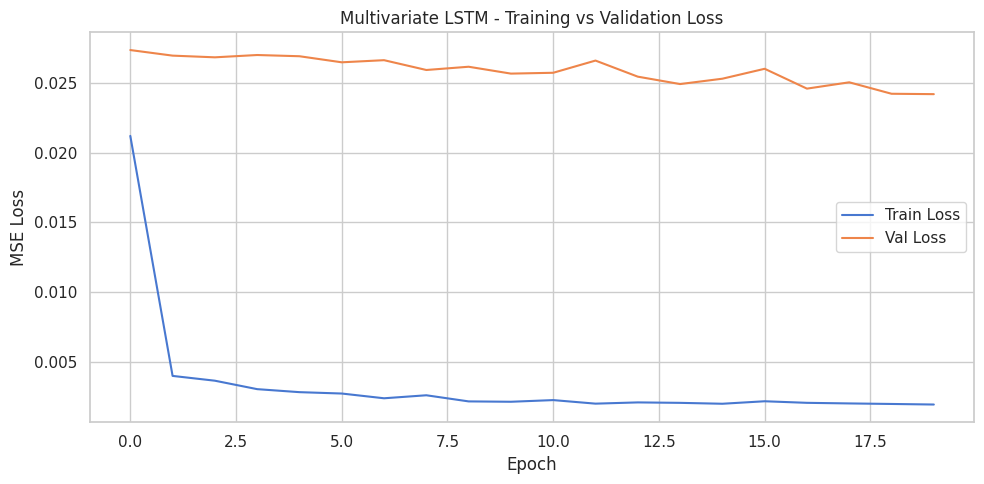

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history_mv.history['loss'], label='Train Loss')
plt.plot(history_mv.history['val_loss'], label='Val Loss')
plt.title('Multivariate LSTM - Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Predict on test set
y_pred_mv_scaled = model_mv.predict(X_test_mv)

# Inverse scale predictions and actuals
y_pred_mv = scaler.inverse_transform(
    np.hstack((y_pred_mv_scaled, np.zeros((len(y_pred_mv_scaled), 4))))  # pad to match shape
)[:, 0]

y_test_mv_orig = scaler.inverse_transform(
    np.hstack((y_test_mv.reshape(-1, 1), np.zeros((len(y_test_mv), 4))))
)[:, 0]

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_mv = np.sqrt(mean_squared_error(y_test_mv_orig, y_pred_mv))
mae_mv = mean_absolute_error(y_test_mv_orig, y_pred_mv)

print(f"Multivariate LSTM RMSE: {rmse_mv:.2f}")
print(f"Multivariate LSTM MAE: {mae_mv:.2f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Multivariate LSTM RMSE: 11829.26
Multivariate LSTM MAE: 7252.62


### Multivarite LSTM_2

In [ ]:
df_lstm = df_daily.copy()

# Extract time components
df_lstm['Day'] = df_lstm['order_date'].dt.day
df_lstm['Month'] = df_lstm['order_date'].dt.month
df_lstm['Year'] = df_lstm['order_date'].dt.year

# Lag features
df_lstm['Sales_Lag1'] = df_lstm['Sales'].shift(1)
df_lstm['Sales_Lag2'] = df_lstm['Sales'].shift(2)

# Moving averages
df_lstm['Sales_MovingAvg_3'] = df_lstm['Sales'].rolling(window=3).mean()
df_lstm['Sales_MovingAvg_7'] = df_lstm['Sales'].rolling(window=7).mean()

# Drop rows with NaNs caused by lags & moving avg
df_lstm.dropna(inplace=True)


In [ ]:


# Select features
features = ['Sales', 'Sales_Lag1', 'Sales_Lag2', 'Sales_MovingAvg_3', 'Sales_MovingAvg_7', 'Day', 'Month', 'Year']
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_lstm[features])


In [ ]:
def create_sequences(data, target_index, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i, target_index])  # Sales is target (index 0)
    return np.array(X), np.array(y)

window_size = 45
X, y = create_sequences(scaled_features, target_index=0, window_size=window_size)


In [ ]:
# Full split
total_len = len(X)
train_end = int(total_len * 0.7)
val_end = int(total_len * 0.8)

# Create splits
X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val     = X[train_end:val_end], y[train_end:val_end]
X_test, y_test   = X[val_end:], y[val_end:]

# Shapes
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (753, 45, 8)
Validation shape: (107, 45, 8)
Test shape: (216, 45, 8)


In [ ]:
# Define stacked LSTM model
model = Sequential()

# First LSTM layer (must return sequences for stacking)
model.add(LSTM(units=64, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=32, activation='tanh'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1))  # Predict next day's sales

# Compile
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0192 - mae: 0.1099 - val_loss: 0.0015 - val_mae: 0.0296
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0033 - mae: 0.0470 - val_loss: 0.0018 - val_mae: 0.0322
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028 - mae: 0.0423 - val_loss: 0.0014 - val_mae: 0.0288
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - mae: 0.0396 - val_loss: 0.0015 - val_mae: 0.0288
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025 - mae: 0.0394 - val_loss: 0.0015 - val_mae: 0.0292
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0024 - mae: 0.0399 - val_loss: 0.0013 - val_mae: 0.0284
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025 - mae: 0.0407 - val_loss: 0.0021 - val_mae: 0.0361
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0023 - mae: 0.0381 - val_loss: 0.0013 - val_mae: 0.0282
Epoch 9/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024 - mae: 0.

In [ ]:
# Predict on test set
y_pred_scaled = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [ ]:
y_pred = scaler.inverse_transform(
    np.hstack((y_pred_scaled, np.zeros((len(y_pred_scaled), 7))))
)[:, 0]

# Inverse transform actuals
y_true = scaler.inverse_transform(
    np.hstack((y_test.reshape(-1, 1), np.zeros((len(y_test), 7))))
)[:, 0]


In [ ]:
rmse_stacked = np.sqrt(mean_squared_error(y_true, y_pred))
mae_stacked = mean_absolute_error(y_true, y_pred)

print(f"Stacked LSTM RMSE: {rmse_stacked:.2f}")
print(f"Stacked LSTM MAE: {mae_stacked:.2f}")

Stacked LSTM RMSE: 11381.64
Stacked LSTM MAE: 7017.87


In [ ]:
# Add early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# Train the stacked LSTM model with longer epochs and early stopping
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0019 - mae: 0.0345 - val_loss: 0.0017 - val_mae: 0.0314
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020 - mae: 0.0354 - val_loss: 0.0014 - val_mae: 0.0288
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019 - mae: 0.0355 - val_loss: 0.0014 - val_mae: 0.0285
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0018 - mae: 0.0338 - val_loss: 0.0018 - val_mae: 0.0322
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017 - mae: 0.0330 - val_loss: 0.0019 - val_mae: 0.0333
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - mae: 0.0320 - val_loss: 0.0014 - val_mae: 0.0286
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018 - mae: 0.0334 - val_loss: 0.0013 - val_mae: 0.0282
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019 - mae: 0.0337 - val_loss: 0.0016 - val_mae: 0.0300
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - lo

In [ ]:
# Predict on test set
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions
y_pred = scaler.inverse_transform(
    np.hstack((y_pred_scaled, np.zeros((len(y_pred_scaled), 7))))
)[:, 0]

y_true = scaler.inverse_transform(
    np.hstack((y_test.reshape(-1, 1), np.zeros((len(y_test), 7))))
)[:, 0]

# Evaluate
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f"Stacked LSTM (EarlyStopped) RMSE: {rmse:.2f}")
print(f"Stacked LSTM (EarlyStopped) MAE: {mae:.2f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Stacked LSTM (EarlyStopped) RMSE: 11522.75
Stacked LSTM (EarlyStopped) MAE: 7178.68


## Ensembling (LSTM + Naïve)

## 🤝 LSTM + Naïve Ensemble Forecast

To leverage both the LSTM's ability to capture temporal patterns and the Naïve model’s short-term accuracy, we use a weighted ensemble:

### 🧮 Formula:

`y_ensemble = α × y_pred_lstm + (1 - α) × y_pred_naive`


In [ ]:
naive_pred = np.roll(y_true, 1)  # shift actuals by 1
naive_pred[0] = y_true[0]  # set first prediction to first actual


In [ ]:
alpha = 0.6  # you can try 0.5, 0.7, etc.
y_ensemble = alpha * y_pred + (1 - alpha) * naive_pred


In [ ]:
ensemble_rmse = np.sqrt(mean_squared_error(y_true, y_ensemble))
ensemble_mae = mean_absolute_error(y_true, y_ensemble)

print(f"Ensemble (LSTM + Naïve) RMSE: {ensemble_rmse:.2f}")
print(f"Ensemble (LSTM + Naïve) MAE: {ensemble_mae:.2f}")


Ensemble (LSTM + Naïve) RMSE: 8513.25
Ensemble (LSTM + Naïve) MAE: 5409.59


<ipython-input-62-e19108b37b32>:15: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


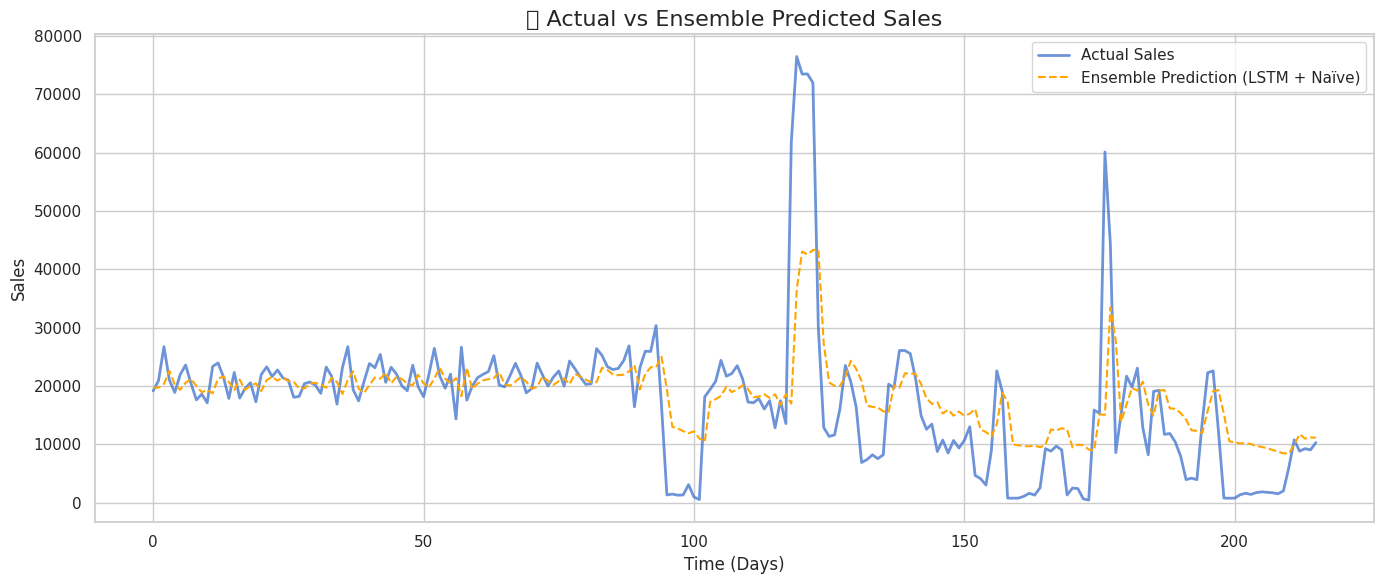

In [ ]:
plt.figure(figsize=(14, 6))

# Plot actual sales
plt.plot(y_true, label='Actual Sales', linewidth=2, alpha=0.8)

# Plot ensemble predictions
plt.plot(y_ensemble, label='Ensemble Prediction (LSTM + Naïve)', linestyle='--', color='orange')

# Formatting
plt.title('📈 Actual vs Ensemble Predicted Sales', fontsize=16)
plt.xlabel('Time (Days)', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plt.savefig('ensemble_forecast.png')

<Figure size 640x480 with 0 Axes>

## 📊 Business Impact of Ensemble Forecasting Model

This ensemble model, combining LSTM and Naïve forecasting, effectively captures both short-term variations and broader temporal patterns in sales data.

### ✅ How the Model Can Be Used:
- **Daily Sales Forecasting**: Helps predict short-term demand with improved accuracy, enabling proactive inventory planning.
- **Anomaly Detection**: Deviations between forecast and actuals can highlight abnormal sales activity (e.g., stockouts, campaigns, fraud).
- **Promotion Planning**: Understand expected sales baseline to quantify lift during marketing campaigns.
- **Resource Allocation**: Supports dynamic allocation of staff, logistics, and operations based on predicted sales volume.

### 💼 Benefits to the Company:
- 🔄 **Reduces overstocking and understocking risks**
- 💰 **Minimizes revenue loss from missed demand**
- 📦 **Improves warehouse and logistics efficiency**
- 📉 **Provides data-driven foundation for sales strategy**

### 🔍 Future Enhancements:
- Incorporate **holiday, weather, or event-based features** for sharper predictions
- Deploy as a **real-time dashboard** for dynamic sales monitoring
- Integrate with **automated replenishment systems**

This model provides a robust, scalable foundation for operational forecasting in data-driven supply chain and retail environments.


In [ ]:
model.save("stacked_lstm_ensemble_final_model.h5")
print("✅ Model saved as 'stacked_lstm_ensemble_final_model.h5'")

✅ Model saved as 'stacked_lstm_ensemble_final_model.h5'
